# Initial Processing of the GEX Data 

This is the processing for the mRNA of the AMO experiment. In order to better identify ambient RNA, for this assay we experimented with spiking in mouse cells into the human cell mixture right before loading. During running of the 10x, had a _slight_ wetting failure. Because of this wetting failure on well 5, the ranked UMI plot doesn't look as nice as it should. For that reason, in the beginning of the notebook, I use the mouse transcripts in order to reliably call human cells. After this, I do regular processing and discover that the well that had the wetting failure seems to mostly produce cells that cluster with the normal populations, but there is one relatively large population that seems to be coming from well 5. This is a caveat of this data, but we accept it and do not analyze the data any further than the clustering and visualization.

# Setup

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import warnings
import itertools as it
import json
import pickle as pkl
import os

from nero import Harmonia
from nero import Nero as nr

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.settings.n_jobs=16

In [3]:
mountpoint = '/data/clue/'
prefix_mrna = mountpoint + 'amo/mrna/'

## Load in the Data

In [ ]:
wells = dict()
for well in range(1,6):
    wells[well] = dict()
    wells[well]['adata_h'] = sc.read_10x_h5(prefix_mrna + "cr/well%s/outs/raw_feature_bc_matrix.h5" % well, genome='hg38')
    wells[well]['adata_h'].var_names_make_unique()
    wells[well]['adata_m'] = sc.read_10x_h5(prefix_mrna + "cr/well%s/outs/raw_feature_bc_matrix.h5" % well, genome='mm10')
    wells[well]['adata_m'].var_names_make_unique()
    print(wells[well]['adata_h'].obs_vector('hg38_______ACE2').sum())

## Load in Colors

In [216]:
with open(mountpoint + 'cond_colors.pkl', 'rb') as file:
    cond_colors = pkl.load(file)['hex']

# Processing

Remove cells and genes that contain 0 counts.

In [ ]:
for well in wells:
    for adata in ['adata_h', 'adata_m']:
        sc.pp.filter_cells(wells[well][adata], min_counts=1)
        sc.pp.filter_genes(wells[well][adata], min_counts=1)
        wells[well][adata + '-filter_cells_n_counts'] = wells[well][adata].obs['n_counts'].sort_values(ascending=False)

## Knee plots

Here I'm line-plotting the ranked genes by each genome, but then scatter-plotting the equivalent UMIs of the opposite genome. This shows a really nice distinction between mouse and human cells, and mouse and human background transcripts.

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(30,12))
for prod, ax in tqdm(list(zip(it.product(range(1,6), ['adata_h', 'adata_m']), np.ravel(ax.T))), total=10):
    series = wells[prod[0]][prod[1] + '-filter_cells_n_counts']
    if prod[1] == 'adata_h':
        ax.scatter(range(len(series)), wells[prod[0]]['adata_m'].obs['n_counts'][series.index.values].values, color='c', alpha=0.1, s=3, linewidth=0)
        ax.plot(series.values, color='y', linestyle='--')
    else:
        ax.scatter(range(len(series)), wells[prod[0]]['adata_h'].obs['n_counts'][series.index.values].values, color='y', alpha=0.1, s=3, linewidth=0)
        ax.plot(series.values, color='c', linestyle='--')
    ax.set_xscale('log')
    ax.set_yscale('log')
# plt.tight_layout()

### Lower Gate
Let's take a closer look at the areas of interest:

In [ ]:
lower_ranges = [(5e3, 4e4), (5e3, 4e4), (3e3, 3e4), (2e3, 3e4), (5.5e4, 1e5)]

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(30,6))
for prod, ax, xlim in tqdm(list(zip(it.product(range(1,6), ['adata_m']), np.ravel(ax.T), lower_ranges)), total=5):
    series = wells[prod[0]][prod[1] + '-filter_cells_n_counts'][int(xlim[0]):int(xlim[1])]
    ax.scatter(range(len(series)), wells[prod[0]]['adata_h'].obs['n_counts'][series.index.values].values, color='y', alpha=0.1, s=3, linewidth=0)
    ax.plot(series.values, color='c', linestyle='--')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(False) # turn off major, or else major will turn off while minor turns on
    ax.grid(which='both',axis='both')
plt.tight_layout()

In [ ]:
lower_vlines = [4e3, 6e3, 3.5e3, 5e3, 6e3]

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(30,6))
for prod, ax, xlim, vline in tqdm(list(zip(it.product(range(1,6), ['adata_m']), np.ravel(ax.T), lower_ranges, lower_vlines)), total=5):
    series = wells[prod[0]][prod[1] + '-filter_cells_n_counts'][int(xlim[0]):int(xlim[1])]
    ax.scatter(range(len(series)), wells[prod[0]]['adata_h'].obs['n_counts'][series.index.values].values, color='y', alpha=0.1, s=3, linewidth=0)
    ax.plot(series.values, color='c', linestyle='--')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(False) # turn off major, or else major will turn off while minor turns on
    ax.grid(which='both',axis='both')
    ax.vlines(vline, 1, 1e4)
plt.tight_layout()

### Upper Gate

In [ ]:
upper_ranges = [(5e4, 9e4), (5e4, 9e4), (3e4, 6e4), (4e4, 8e4), (8e4, 2e5)]

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(30,6))
for prod, ax, xlim in tqdm(list(zip(it.product(range(1,6), ['adata_m']), np.ravel(ax.T), upper_ranges)), total=5):
    series = wells[prod[0]][prod[1] + '-filter_cells_n_counts'][int(xlim[0]):int(xlim[1])]
    ax.scatter(range(len(series)), wells[prod[0]]['adata_h'].obs['n_counts'][series.index.values].values, color='y', alpha=0.1, s=3, linewidth=0)
    ax.plot(series.values, color='c', linestyle='--')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(False) # turn off major, or else major will turn off while minor turns on
    ax.grid(which='both',axis='both')
plt.tight_layout()

In [ ]:
upper_vlines = [1.5e4, 1.5e4, 1.4e4, 2.1e4, 2e4]

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(30,6))
for prod, ax, xlim, vline in tqdm(list(zip(it.product(range(1,6), ['adata_m']), np.ravel(ax.T), upper_ranges, upper_vlines)), total=5):
    series = wells[prod[0]][prod[1] + '-filter_cells_n_counts'][int(xlim[0]):int(xlim[1])]
    ax.scatter(range(len(series)), wells[prod[0]]['adata_h'].obs['n_counts'][series.index.values].values, color='y', alpha=0.1, s=3, linewidth=0)
    ax.plot(series.values, color='c', linestyle='--')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(False) # turn off major, or else major will turn off while minor turns on
    ax.grid(which='both',axis='both')
    ax.vlines(vline, 1, 1e4)
plt.tight_layout()

In [ ]:
ranges = list()
for l_r, l_v, u_r, u_v in zip(lower_ranges, 
                              lower_vlines, 
                              upper_ranges, 
                              upper_vlines):
    ranges.append((l_r[0] + l_v, u_r[0] + u_v))

In [ ]:
umi_cutoffs = [250, 250, 400, 400, 250]

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(30,6))
for prod, ax, xlim, umi_c in tqdm(list(zip(it.product(range(1,6), ['adata_m']), np.ravel(ax.T), ranges, umi_cutoffs)), total=5):
    series = wells[prod[0]][prod[1] + '-filter_cells_n_counts']
    ax.scatter(range(len(series)), wells[prod[0]]['adata_h'].obs['n_counts'][series.index.values].values, color='y', alpha=0.1, s=3, linewidth=0)
    ax.plot(series.values, color='c', linestyle='--')
    ax.plot([1, 1e6], [umi_c, umi_c], color='k')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(False) # turn off major, or else major will turn off while minor turns on
    ax.grid(which='both',axis='both')
    ax.vlines(xlim[0], 1, 1e4)
    ax.vlines(xlim[1], 1, 1e4)    
plt.tight_layout()

If you try to visualize mentally, the knee plot for the opposite genome is just a projection onto the Y axis of each plot. For the first 4 wells, this would actually capture most of the cells I'm capturing with the above visualization method. However, for well 5, that would grab a TON of what I think is background human RNA. We can salvage the data from that last well using this method because we're excluding that background.

## Remove Background

I would like to subset the drops and separate the drops into those with cells and those with background. Because there's so few in background as compare to droplets, I will simply drop those in the background from further processing.

In [ ]:
for prod, xlim, umi_c in tqdm(list(zip(it.product(range(1,6), ['adata_m']), ranges, umi_cutoffs)), total=5):
    series = wells[prod[0]][prod[1] + '-filter_cells_n_counts'][int(xlim[0]):int(xlim[1])]
    
    # need to take overlap because there will be a few bad apples (min_count=0) that were removed from adata_h 
    overlap = np.intersect1d(series.index.values, wells[prod[0]]['adata_h'].obs_names, assume_unique=True)
    
    wells[prod[0]]['adata_h'] = wells[prod[0]]['adata_h'][overlap].copy()
    
    # make a new covariate in the obs
    background_list = list()
    for count in wells[prod[0]]['adata_h'].obs['n_counts']:
        if count < umi_c:
            background_list.append('True')
        else:
            background_list.append('False')
    wells[prod[0]]['adata_h'].obs['background'] = background_list

In [ ]:
for well in wells:
    print(well)
    print(wells[well]['adata_h'][wells[well]['adata_h'].obs['background'] == 'True'])
    print(wells[well]['adata_h'][wells[well]['adata_h'].obs['background'] == 'False'])
    print('')

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(30,6))
for well, ax in tqdm(list(zip(wells, np.ravel(ax.T)))):
    df = wells[well]['adata_h'].obs[['n_counts','background']].sort_values('n_counts', ascending=False).copy()
    df['rank'] = range(len(df))
    ax.scatter(df[df['background'] == 'False']['rank'].values, 
               df[df['background'] == 'False']['n_counts'].values, 
               color='g', s=3, linewidth=0)
    ax.scatter(df[df['background'] == 'True']['rank'].values, 
               df[df['background'] == 'True']['n_counts'].values, 
               color='r', s=3, linewidth=0)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(False) # turn off major, or else major will turn off while minor turns on
    ax.grid(which='both',axis='both') 
    ax.set_xlim(1,1e5)
    ax.set_ylim(1,5e4)
plt.tight_layout()

Make a new object for only filtered cells.

In [ ]:
for well in wells:
    wells[well]['adata_filt'] = wells[well]['adata_h'][wells[well]['adata_h'].obs['background'] == 'False'].copy()
    wells[well]['adata_filt'].obs.drop('background', axis=1, inplace=True)

In [ ]:
wells[1]['adata_filt']

## Percent Mito Filtration

In [ ]:
for well in wells:
    genelist = wells[well]['adata_filt'].var_names.tolist()
    mito_genes_names = [gn for gn in genelist if gn.startswith('hg38_______MT-')]
    mito_genes = [genelist.index(gn) for gn in mito_genes_names]
    mito_counts = np.ravel(np.sum(wells[well]['adata_filt'][:, mito_genes].X, axis=1))
    wells[well]['adata_filt'].obs['percent_mito'] = mito_counts / wells[well]['adata_filt'].obs['n_counts'].values

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(30, 5))
for well, ax in zip(wells, ax):
    ax.hist(wells[well]['adata_filt'].obs['percent_mito'].values,bins=200,density=True);

In [ ]:
for well in wells:
    wells[well]['adata_filt'] = wells[well]['adata_filt'][wells[well]['adata_filt'].obs['percent_mito'] < 0.1].copy()

Export the filtered barcodes for demuxlet:

In [ ]:
# for well in wells:
#     with open(prefix_mrna + 'vals/well%s_filt_bcs.tsv' % well,'w') as file:
#         for obs in wells[well]['adata_filt'].obs_names:
#             file.write(obs + '\n')

# Import `popscle` Results

I merged all the bams and changed the gem-group number at the end of the barcodes. I then ran freemuxlet using the list of good sites from Hyun. First, I will split up the output according to the wells it came from:

In [ ]:
wellsplit = dict()
wellsplit_dir = prefix_mrna + 'demux/freemux/wellsplit/'
if not os.path.exists(wellsplit_dir):
    os.mkdir(wellsplit_dir)
for well in range(1, 6):
    wellsplit[well] = open(wellsplit_dir + 'well%d.samples' % well, 'w')
with open(prefix_mrna + 'demux/freemux/freemux.clust1.samples', 'r') as file:
    header = file.readline()
    for well in range(1, 6):
        wellsplit[well].write(header)
    for line in file:
        bc = line.split('\t')[1]
        well = int(bc.split('-')[-1])
        wellsplit[well].write(line)
for well in range(1, 6):
    wellsplit[well].close()

In [ ]:
for well in wells:
    wells[well]['freemux'] = Harmonia.MuxOut(wellsplit_dir + 'well%s.samples' % well)

In [ ]:
deconvolution = pd.DataFrame(index=range(1,6), columns=[str(i) for i in range(5)])

In [ ]:
for i in deconvolution.index:
    for c in deconvolution.columns:
        deconvolution.loc[i, c] = sum(wells[i]['freemux'].sng()['BEST.GUESS'] == c)

In [ ]:
deconvolution

In [ ]:
deconvolution.to_csv(prefix_mrna + 'vals/deconvolution_mrna.csv')

In [ ]:
plt.figure(figsize=(5,4.4))
sns.heatmap(deconvolution[['2', '4', '1', '3', '0']].astype(int), vmin=0, vmax=6000);
plt.ylabel('Well')
plt.xlabel('Anonymous Donor');

High signal to noise of off diagonal-to-diagonal elements shows that the AMO scheme works. Now to attach covariates to the donors and then stimulation conditions.

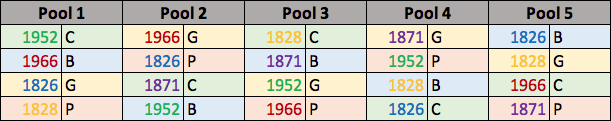

So, based on our scheme, it looks like these are the mappings, in order from 0 to 4:

In [ ]:
donor_map = ['52', '26', '71', '66', '28']

In [222]:
# mismaps are represented by 0
condition_map = {1: ['C', 'G', '0', 'B', 'P'],
                 2: ['B', 'P', 'C', 'G', '0'], 
                 3: ['G', '0', 'B', 'P', 'C'], 
                 4: ['P', 'C', 'G', '0', 'B'], 
                 5: ['0', 'B', 'P', 'C', 'G']}

And now, lets generate some covariate DataFrames so we can merge it onto the data.

In [ ]:
for well in wells:
    wells[well]['covar_df'] = pd.DataFrame(index=[str(i) for i in range(5)], columns=['ind','cond'])
    wells[well]['covar_df']['ind'] = donor_map
    wells[well]['covar_df']['cond'] = condition_map[well]

Rename barcodes to match what I changed them to outside this notebook.

In [ ]:
for well in wells:
    wells[well]['adata_filt'].obs_names = [i[:16] + '-%s' % well for i in wells[well]['adata_filt'].obs_names]

In [ ]:
for well in wells:
    wells[well]['adata_sng'] = Harmonia.ann_merge(wells[well]['adata_filt'], wells[well]['freemux'].sng(), covars=wells[well]['covar_df'])

In [ ]:
concat = wells[1]['adata_sng'].concatenate(wells[2]['adata_sng'], 
                                            wells[3]['adata_sng'], 
                                            wells[4]['adata_sng'], 
                                            wells[5]['adata_sng']) # I really shouldn't do this, I should go back and run cellranger aggr, but for now just concatenate

In [ ]:
concat.var['n_counts'] = concat.var[[i for i in concat.var.columns if i.startswith('n_counts')]].sum(axis=1)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(len(concat.var_names)), 
         concat.var['n_counts'].sort_values(ascending=False).values, 
         color='k')
plt.grid(False)
plt.grid(True, 'both', 'both')
plt.xscale('log')
plt.yscale('log')

In [ ]:
# remove any genes that are now empty
sc.pp.filter_genes(concat, min_counts=20)

In [ ]:
concat.var_names = [i[11:] for i in concat.var_names] # get rid of the hg38_______

In [6]:
path = prefix_mrna + 'h5ads/concat_1.h5ad'

# concat.write_h5ad(path)
concat = sc.read_h5ad(path)

# Dimensionality Reduction and Clustering

In [7]:
sc.pp.filter_genes(concat, min_counts=1, inplace=True) # keep as many genes as possible
sc.pp.normalize_per_cell(concat, counts_per_cell_after=1e6)
sc.pp.log1p(concat)
sc.pp.scale(concat)
sc.pp.combat(concat, key='batch')
sc.pp.scale(concat)
sc.pp.pca(concat, n_comps=100)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Standardizing Data across genes.

Found 5 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments



/home/ssm-user/miniconda3/envs/clue/lib/python3.6/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data

computing PCA
    with n_comps=100
    finished (0:08:26)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


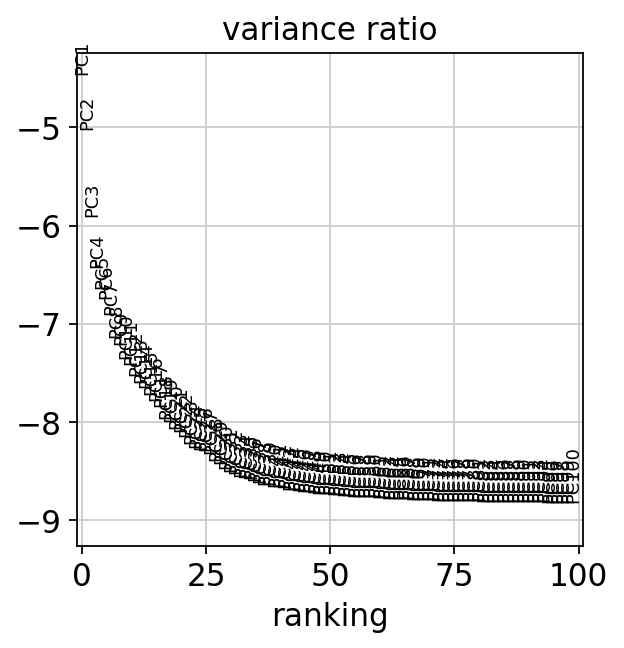

In [8]:
sc.pl.pca_variance_ratio(concat,log=True, n_pcs=100)

In [9]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(concat, n_neighbors=15, n_pcs=60, random_state=0) # using all available embeddings, numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 60
    computed neighbors (0:00:23)
    computed connectivities (0:00:05)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)


In [10]:
sc.tl.umap(concat, random_state=0)

computing UMAP
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:33)


In [242]:
sc.tl.leiden(concat, resolution=0.2, random_state=0)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:24)


In [243]:
concat.uns['cond_colors'] = [cond_colors[i] for i in concat.obs['cond'].cat.categories]

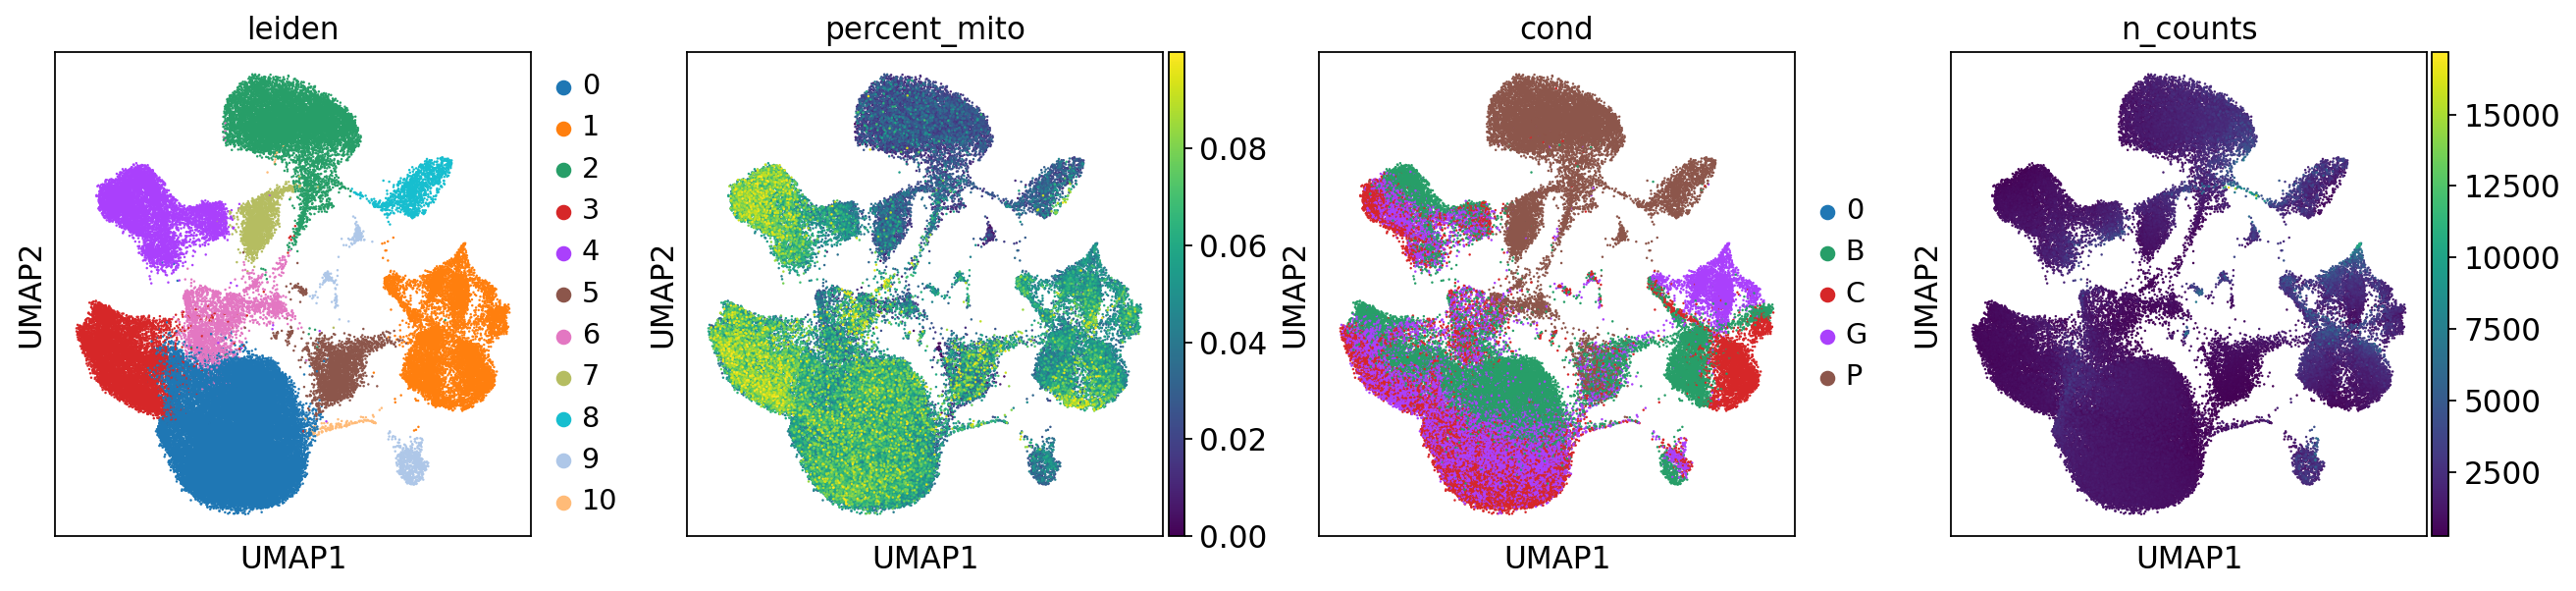

In [244]:
sc.pl.umap(concat,color=['leiden', 'percent_mito', 'cond', 'n_counts'], size=5);

In [13]:
batches = concat.obs['batch'].unique() # get a list of the batches
# make a new column in the `.obs` for each batch that is of dtype `int` and that just takes on values of 0 and 1 so that it gets plotted as a continuous variable instead of a categorical one
for batch in batches:
    concat.obs['batch_%s' % batch] = (concat.obs['batch'] == batch).astype(int)

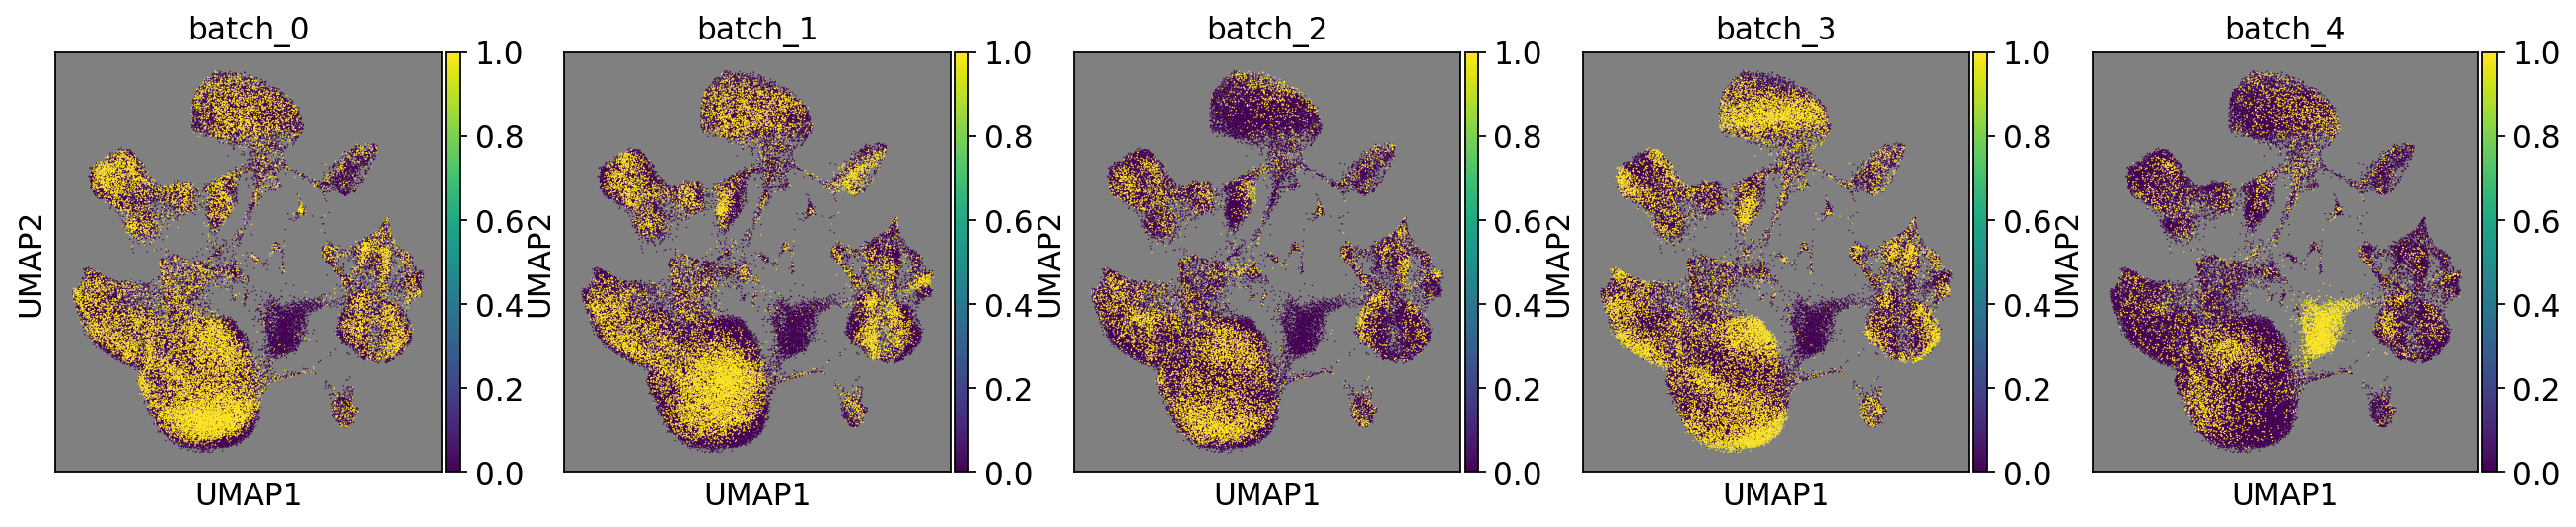

In [14]:
fig, ax = plt.subplots(1, 5, figsize=(20,3.5))
# make a new column in the `.obs` for each batch that is of dtype `int` so that it gets plotted as a continuous variable instead of a categorical one
for batch, ax in zip(batches, np.ravel(ax)):
    ax.set_facecolor('gray')
    sc.pl.umap(concat, color=['batch_%s' % batch], ax=ax, sort_order=True, show=False, return_fig=False)

There is a lone cluster coming from well 5 (`batch_4`). Even well 4 (`batch_3`) is showing some polarization within clusters as well. I will dive a bit deeper into that cluster. First let's see which genes are specifically marking it.

# Differential Expression

ranking genes
    consider 'leiden' groups:
    with sizes: [31682  9289  9248  7809  6671  2627  2607  1880  1280   651   163   103
   140]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:01)


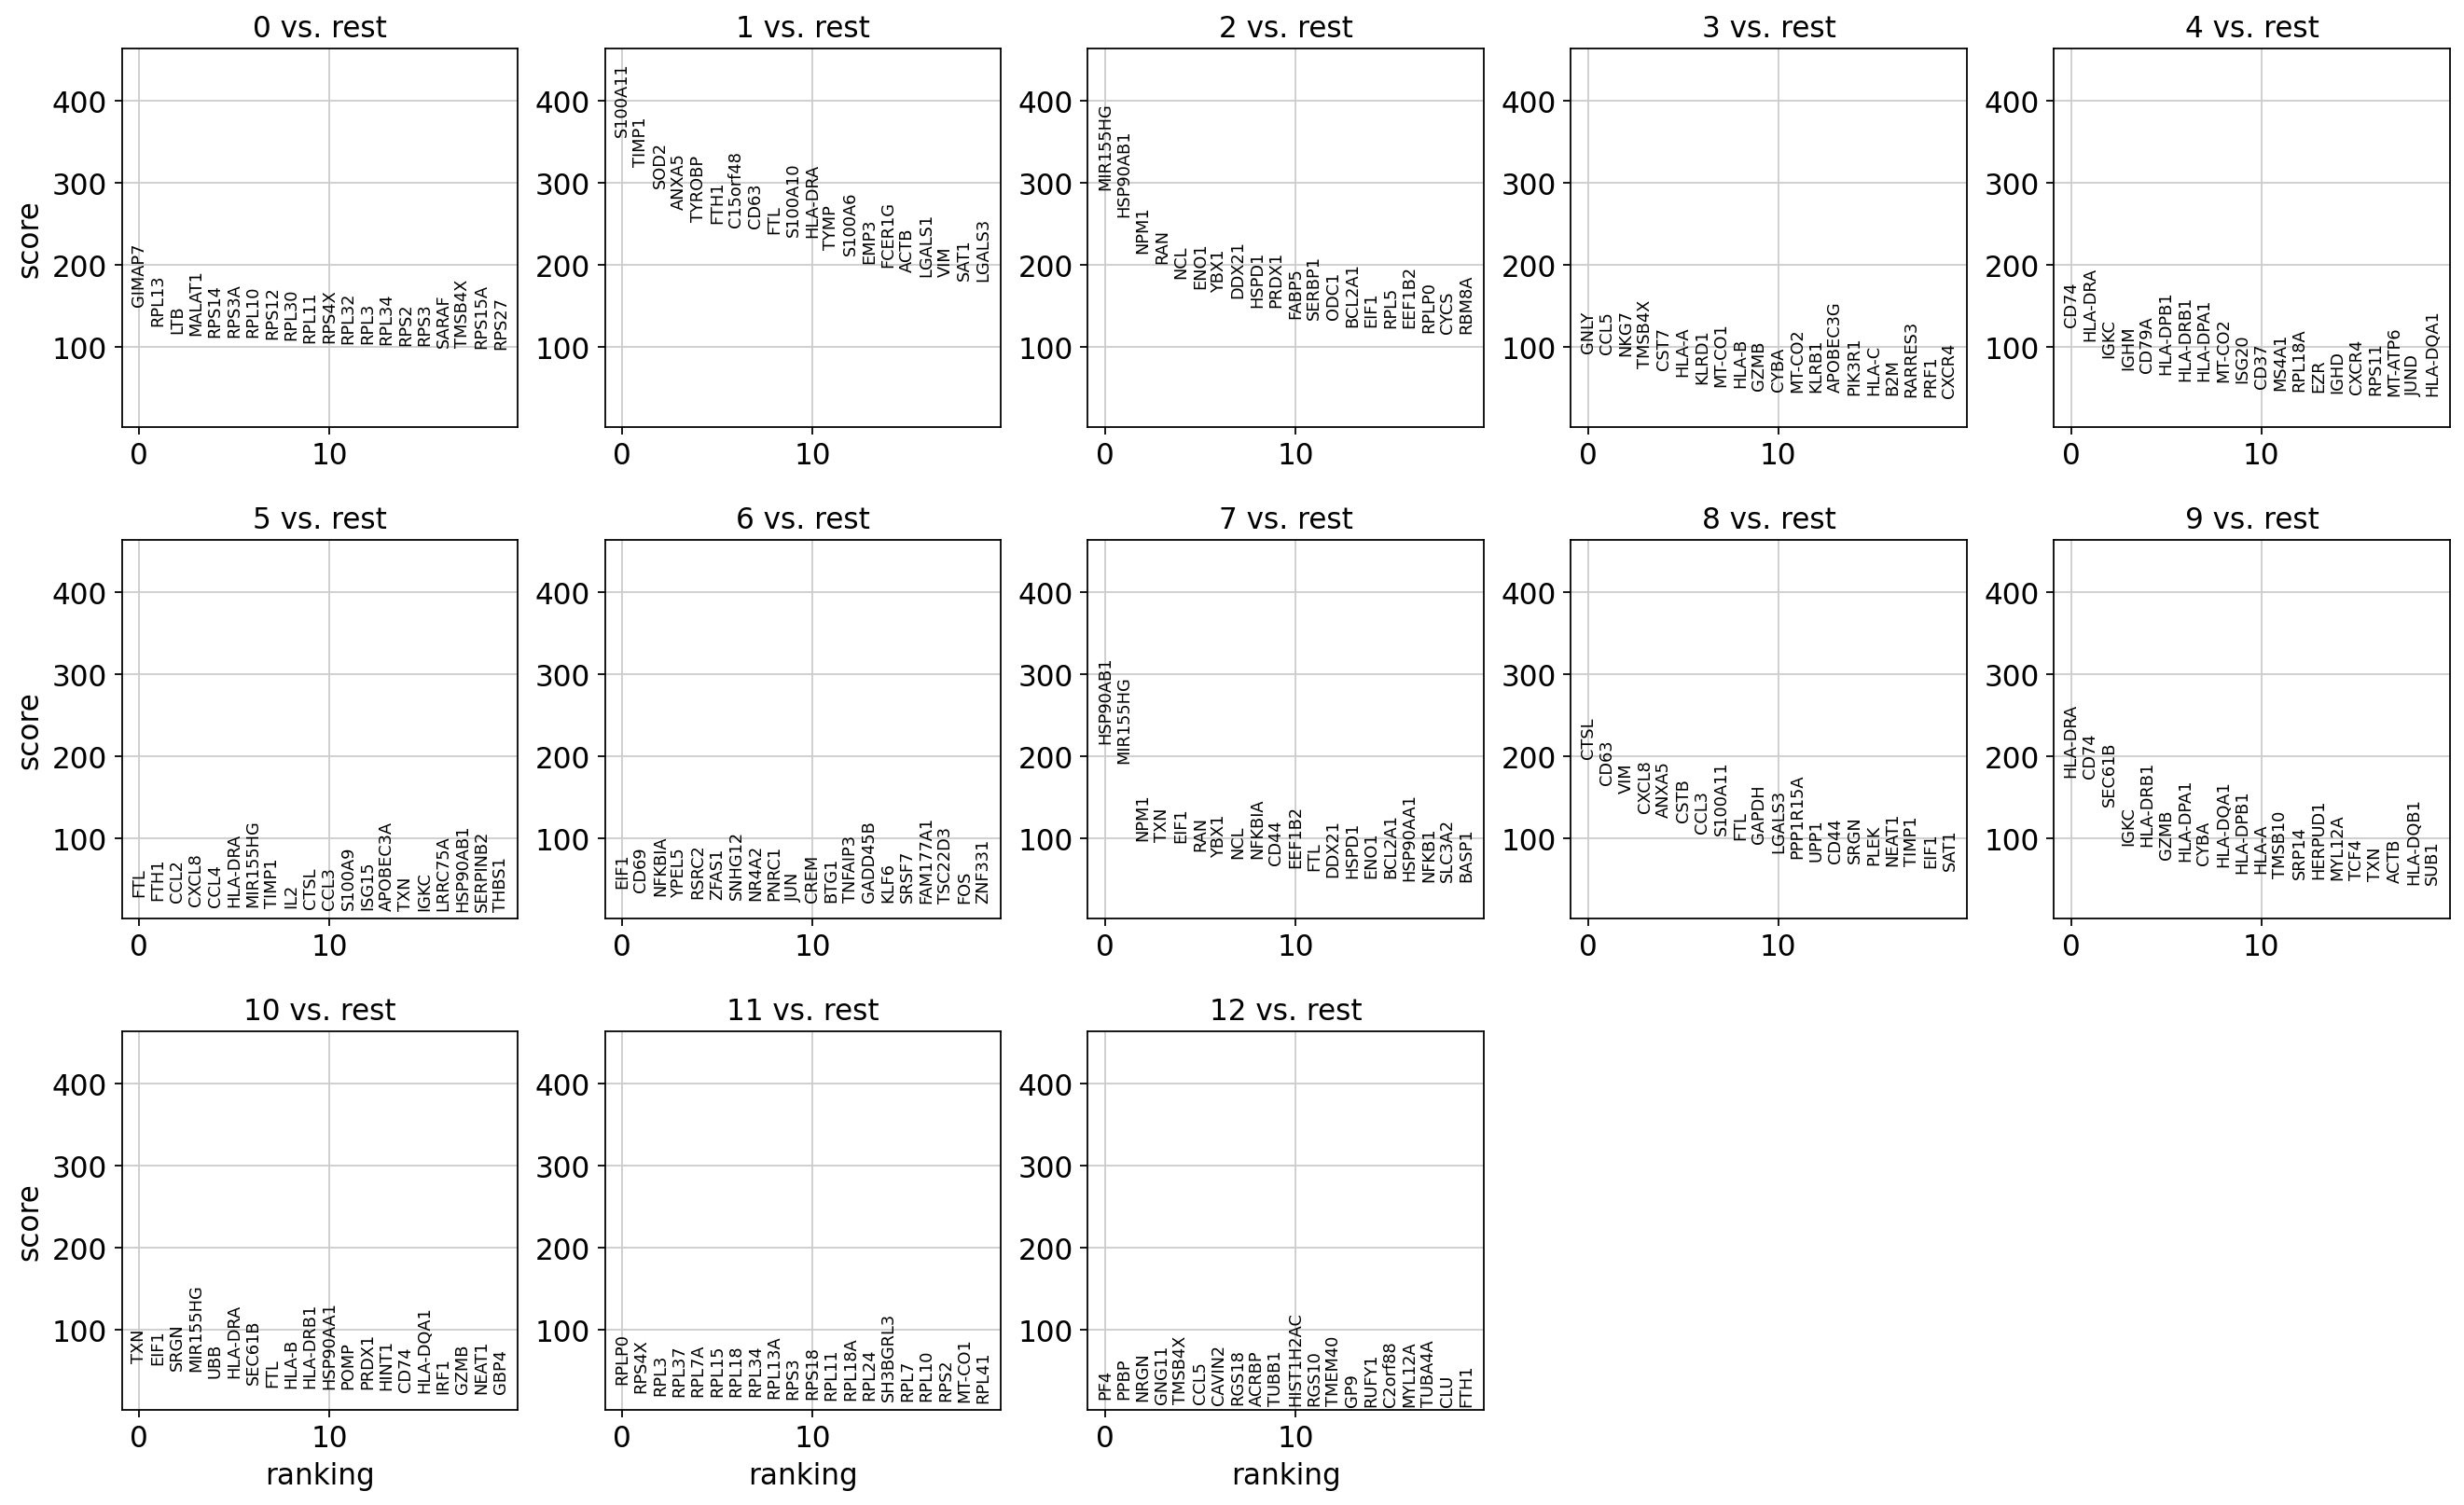

In [232]:
# sc.settings.verbosity = 4
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat, groupby='leiden', method='t-test')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(concat, ncols=5)
sc.settings.verbosity = 4

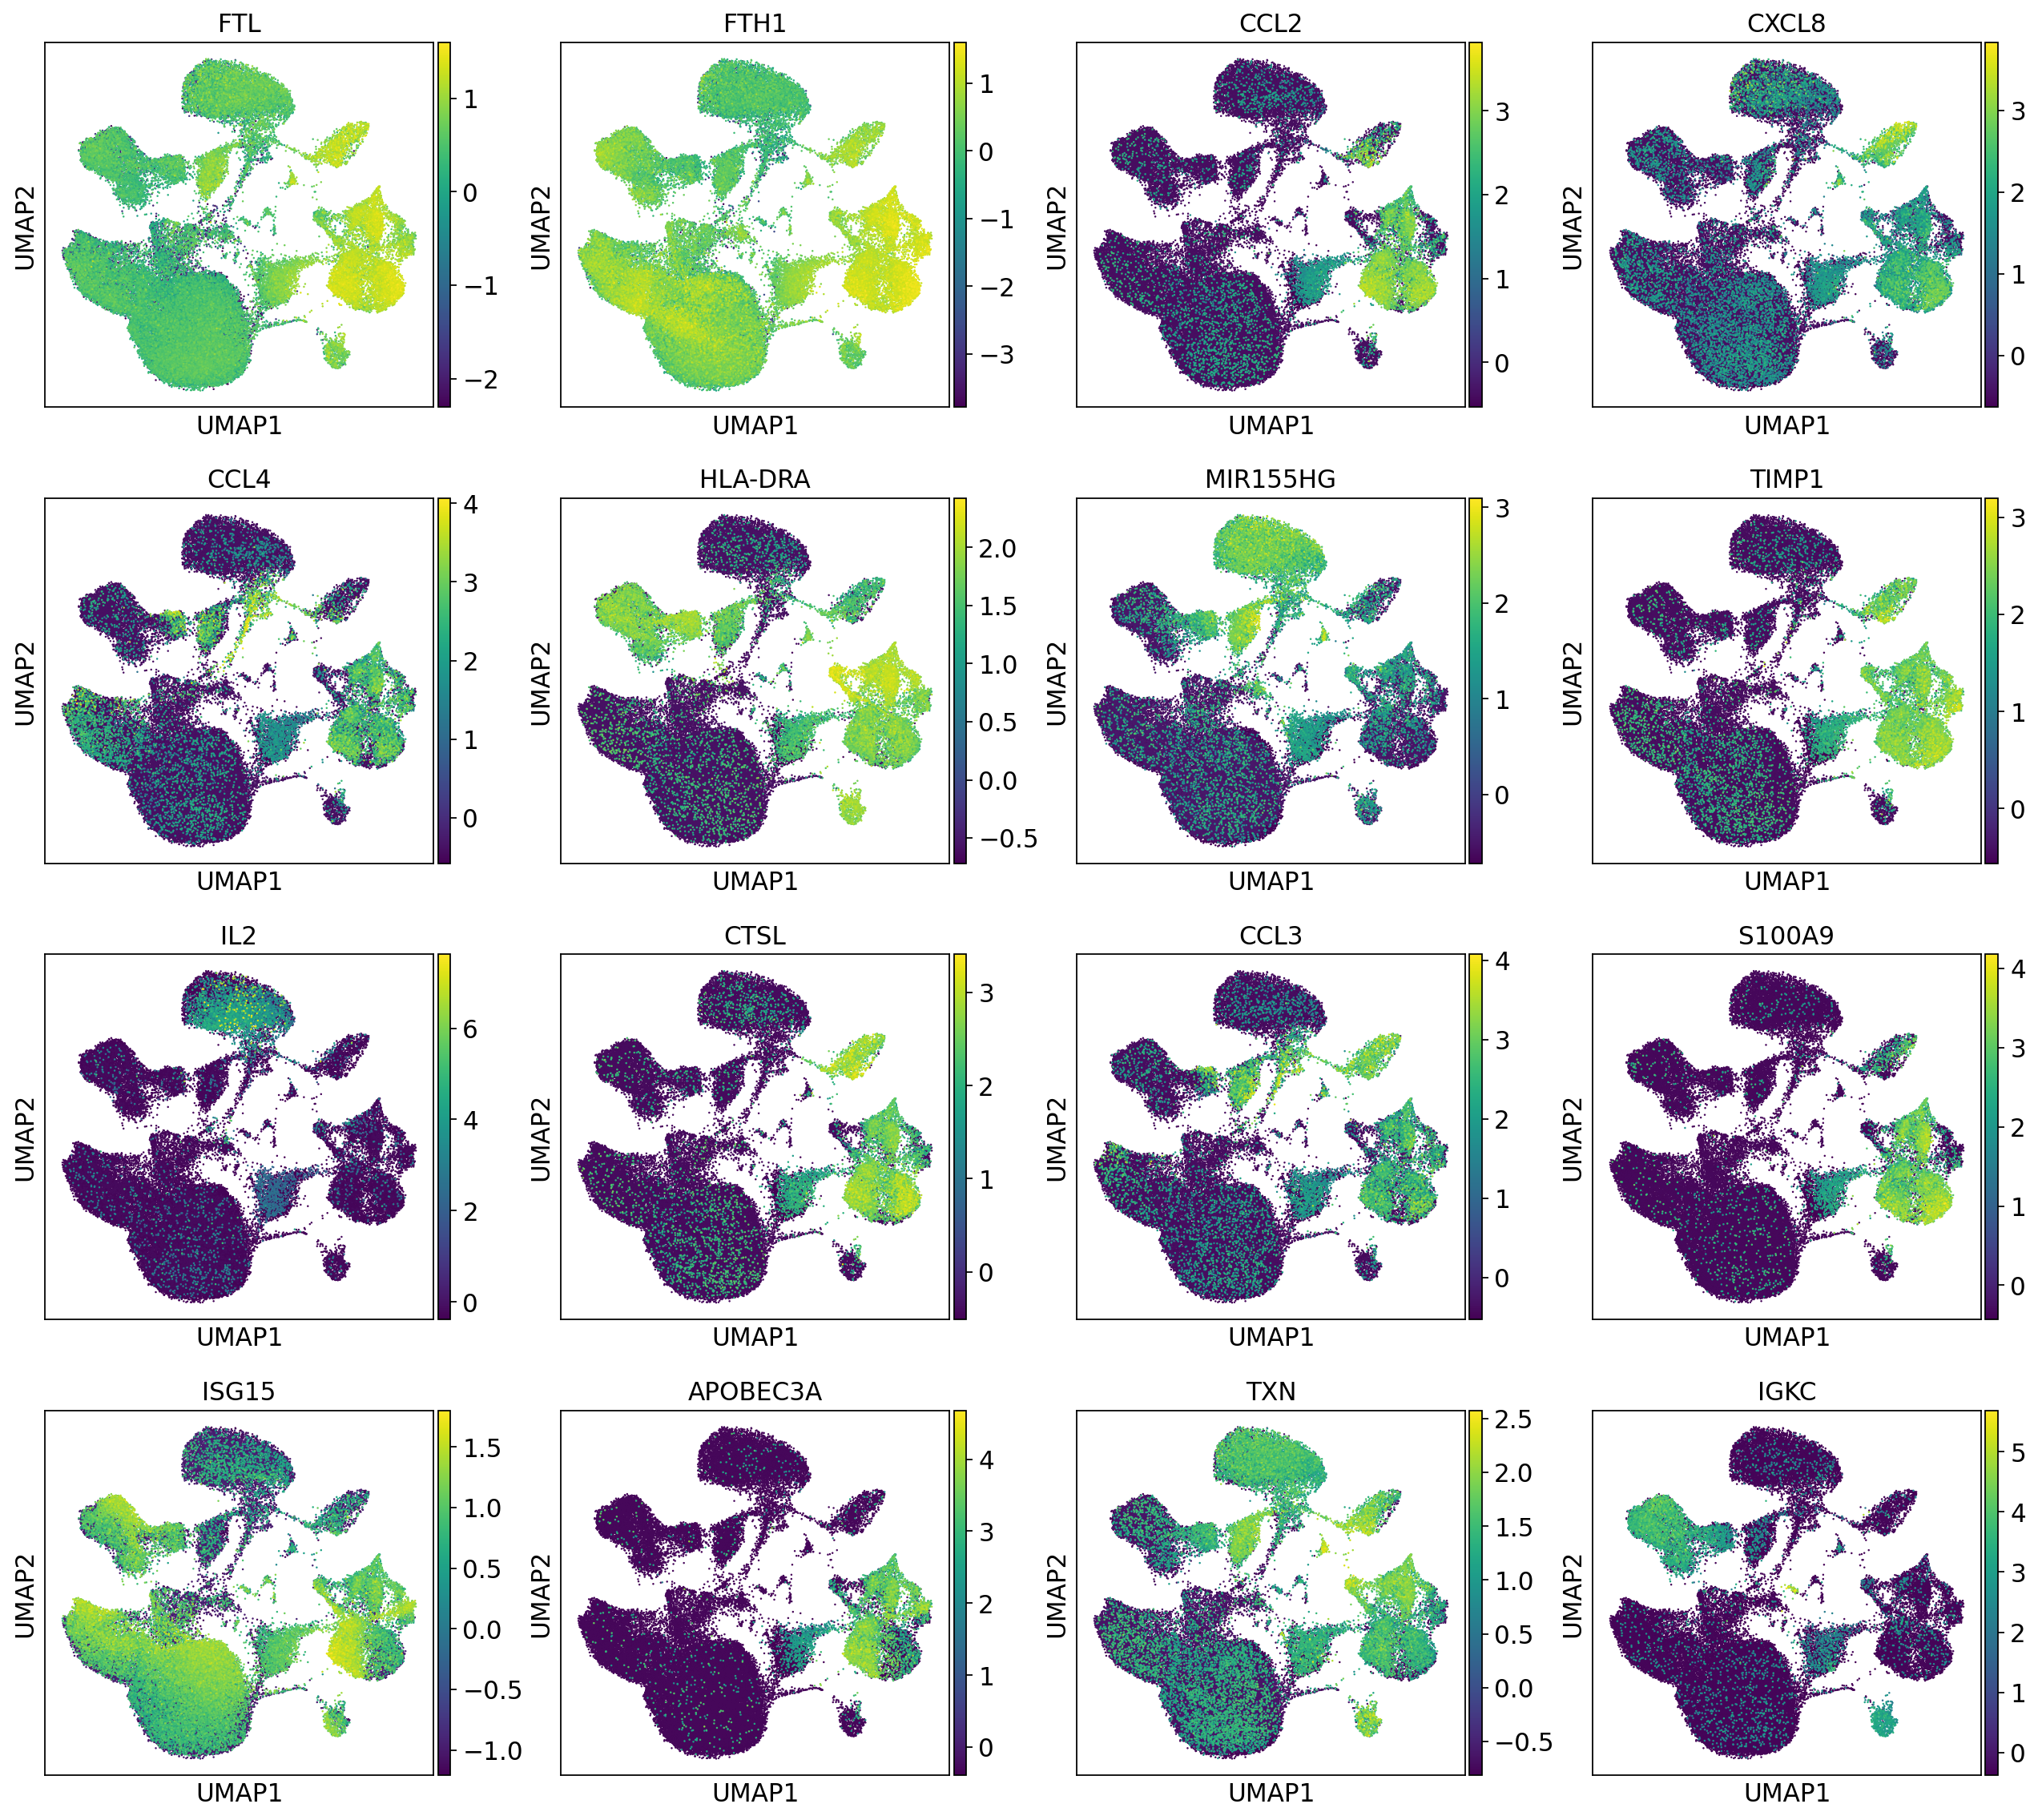

In [233]:
sc.pl.umap(concat,color=[i for i in concat.uns['rank_genes_groups']['names']['5'][:16]], size=5);

It looks like it expresses many markers unique to the myeloid cells, but also IL2 which seems to be unique to that T cell PMA cluster up top. Seems like just low quality droplets with a mess of different transcripts, likely from the wetting failure. 

# Subcluster

In [245]:
sub_concats = dict() # put the new subsetted concat objects in a dictionary of concats
for i in ['9']:
    sub_concats[i] = concat[concat.obs['leiden'] == i].copy()

running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


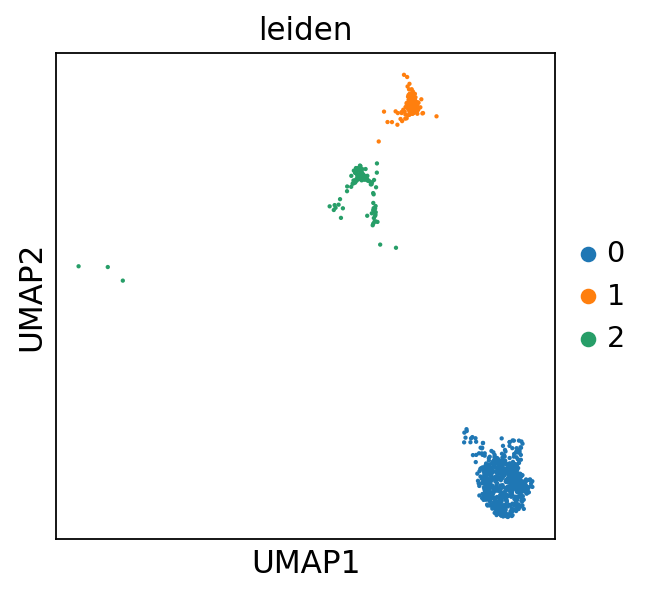

In [246]:
sc.tl.leiden(sub_concats['9'], resolution=0.2) # subcluster them using Leiden
sc.pl.umap(sub_concats['9'], color='leiden', size=15)

Map them back to the clusters on the original `adata`.

In [ ]:
concat = nr.subcluster_mapper(concat, sub_concats)

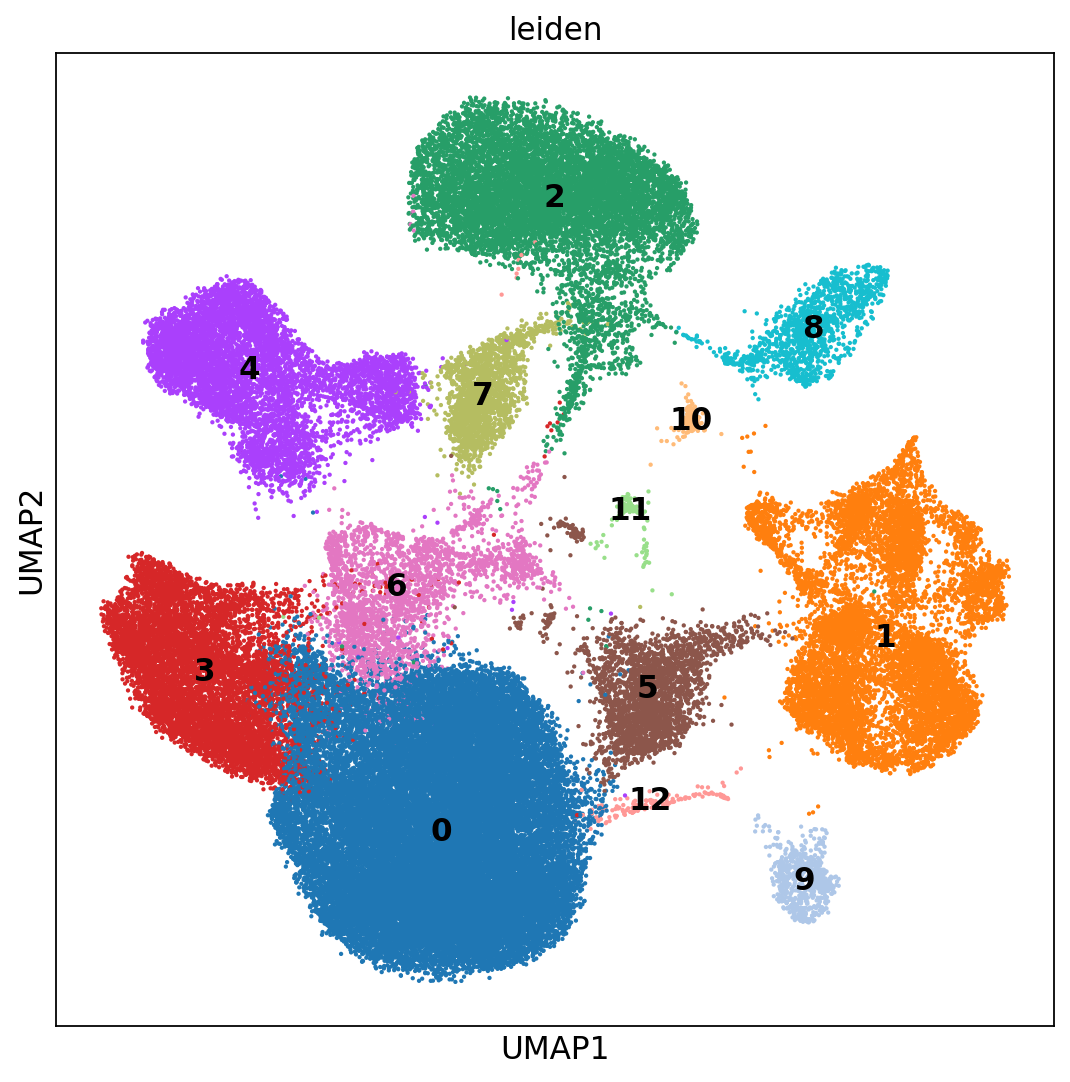

In [248]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.umap(concat, color=['leiden'], ax=ax, size=15, legend_loc='on data', palette=sc.pl.palettes.default_20)

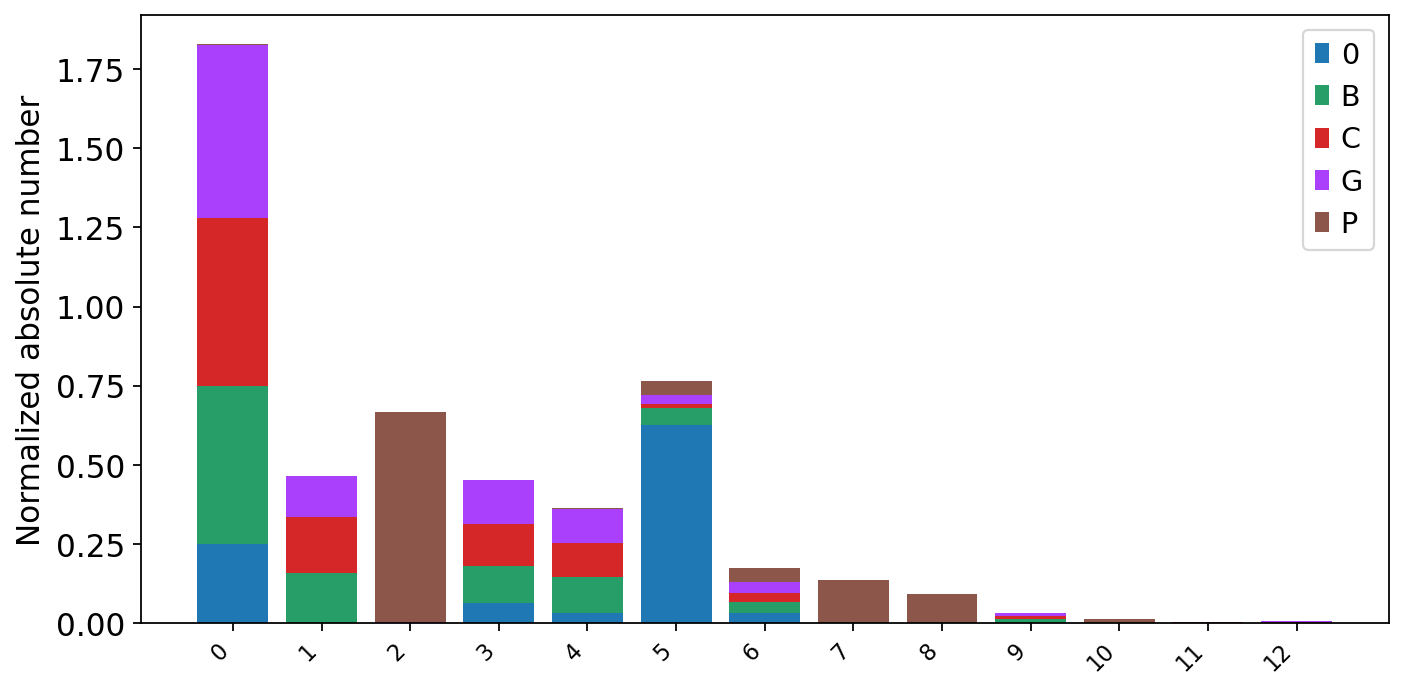

In [299]:
nr.prop_col_chart(concat, group='cond', x='leiden', norm=True, prop=False);

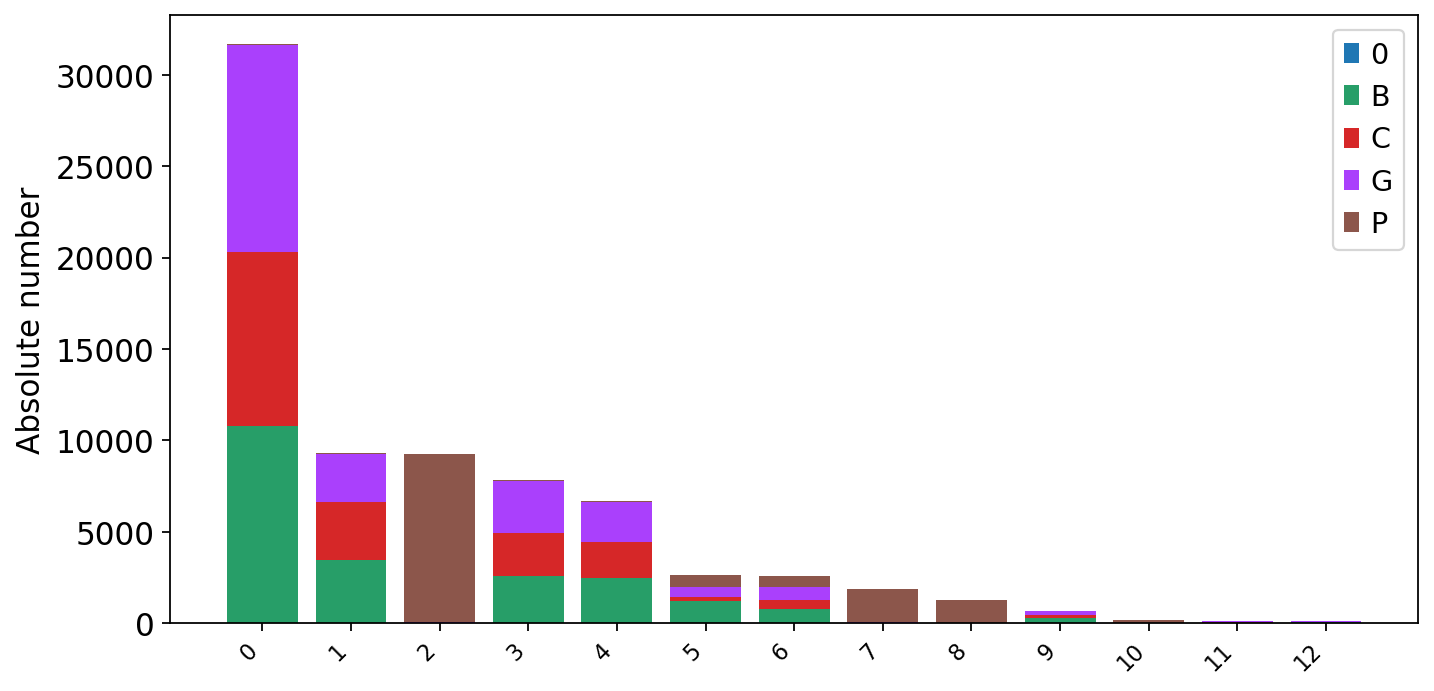

In [300]:
nr.prop_col_chart(concat, group='cond', x='leiden', norm=False, prop=False);

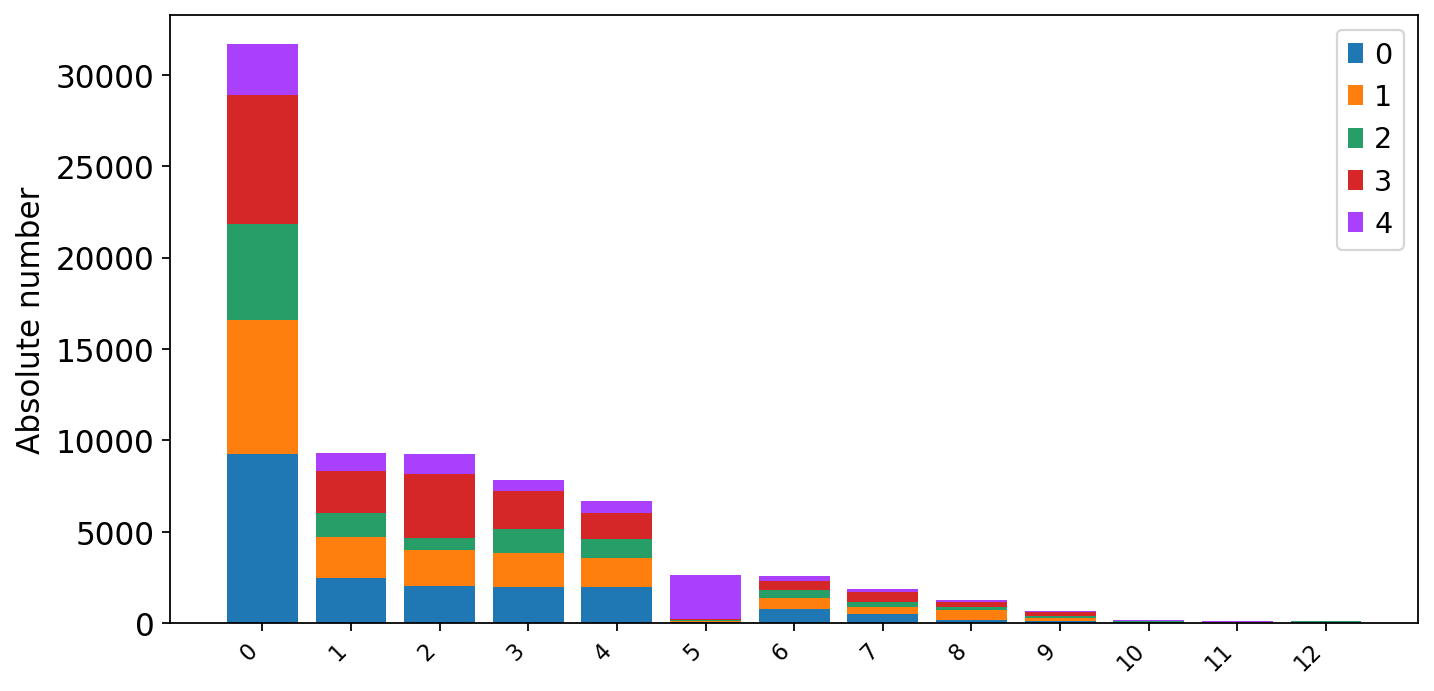

In [301]:
nr.prop_col_chart(concat, group='batch', x='leiden', norm=False, prop=False);

We see that although there are very few mis-mappings (`'0'`) in total, they are disproportionately represented in cluster 5, which is almost entirely derived from `batch_4`. I will therefore remove this cluster and the mis-mapped observations.

In [302]:
concat = concat[concat.obs['leiden'] != '5'].copy() 
concat = concat[concat.obs['cond'] != '0'].copy() 

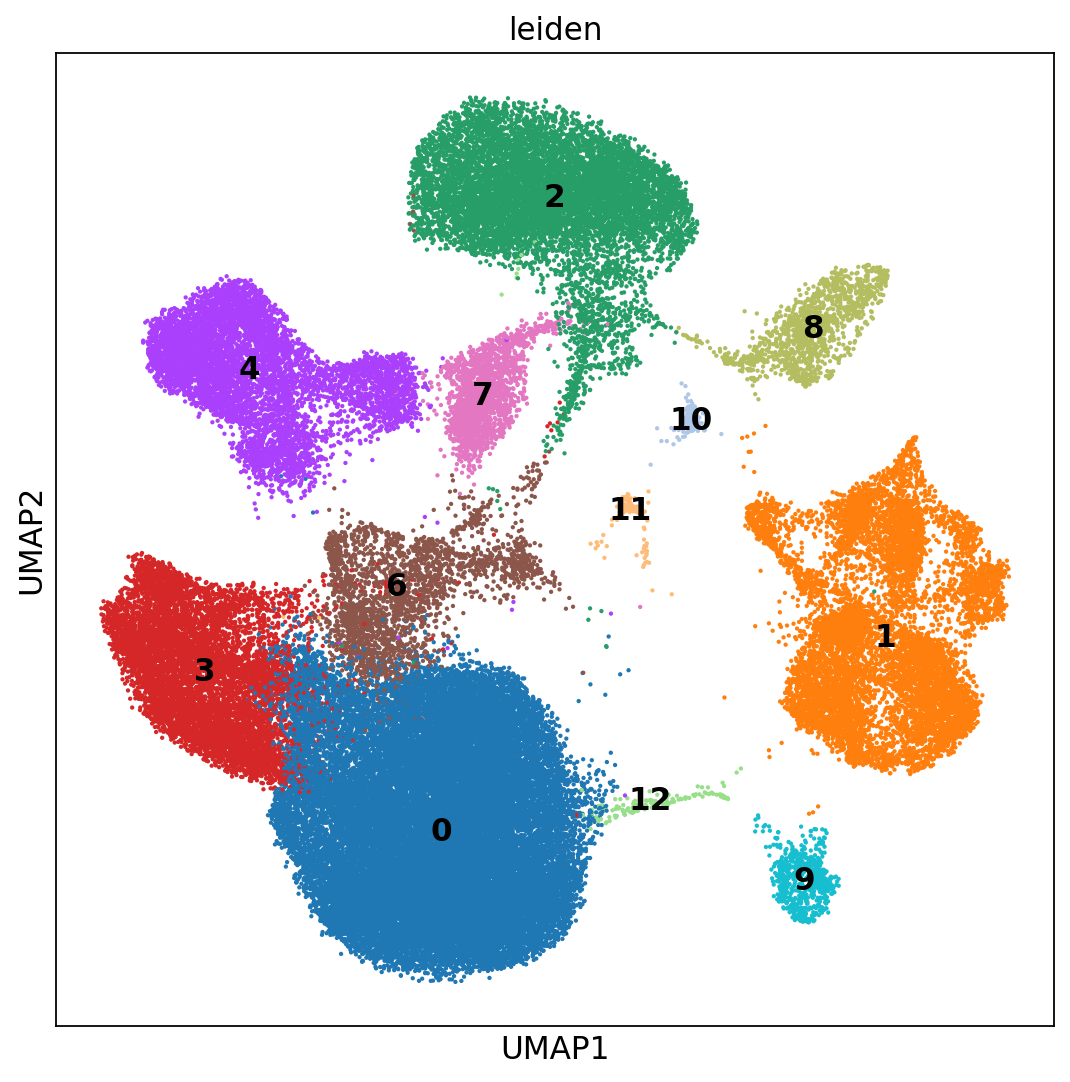

In [303]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.umap(concat, color=['leiden'], ax=ax, size=15, legend_loc='on data', palette=sc.pl.palettes.default_20)

In [4]:
path = prefix_mrna + 'h5ads/concat_2.h5ad'

# concat.write_h5ad(path)
concat = sc.read_h5ad(path)

In [15]:
dist = concat.obsp['distances']
conn = concat.obsp['connectivities']

In [13]:
distances = np.array([dist[i, j] for i, j in zip(*dist.nonzero())])

In [ ]:
connectivities = np.array([dist[i, j] for i, j in zip(*conn.nonzero())])

In [ ]:
plt.hist(distances, bins=100);
plt.yscale('log')

In [ ]:
plt.hist(connectivities, bins=100);
plt.yscale('log')